# Persistence diagrams from ensembles
This script makes some of the plots from the paper. It assumes that you have run generate_ensembles.py first to create a Congressional ensembles for Pennsylvania. Only Congressional (18 districts) is represented here, but it's easy to adapt to other scales, or even other states. 

In [1]:
from gerrychain import Graph, Election, updaters, Partition, constraints, MarkovChain
from gerrychain.updaters import cut_edges
from gerrychain.proposals import recom, propose_random_flip
from gerrychain.tree import recursive_tree_part
from gerrychain.accept import always_accept
from gerrychain.constraints import single_flip_contiguous
import numpy as np
import operator
from functools import partial
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import math
import pickle
import sys, os
import networkx as nx
from collections import defaultdict
import bottleneck_distance
matplotlib.rcParams['savefig.pad_inches'] = 0

## These functions are for computing Frechet means

In [2]:
def pd_point_mean(V):
    '''
    Computes the mean of a vector of points, some of which can be 'd' for diagonal.
    '''
    num_diag = len([v for v in V if v == 'd'])
    if num_diag == len(V):
        return 'd' #only diagonal points
    
    nondiag_X = [v[0] for v in V if v != 'd']
    nondiag_Y = [v[1] for v in V if v != 'd']
    w = (np.mean(nondiag_X), np.mean(nondiag_Y))
    wdelta = ((w[1]+w[0])/2, (w[1]+w[0])/2) #closeset point on diagonal
    k = len(nondiag_X)
    m = len(V)
    
    return ((k*w[0]+(m-k)*wdelta[0])/m, (k*w[1]+(m-k)*wdelta[1])/m)
    

In [3]:
from scipy.optimize import linear_sum_assignment as LSA
def match_Hungarian(pd, Y):
    '''
    Matches points in pd to points in Y or the diagonal in Y.
    
    Returns: list of lists containing the points matched to each y in Y.
    '''
    longest_length = len(pd) + len(Y)
    M = np.zeros((longest_length, longest_length)) #cost matrix
    for i in range(longest_length): #pd
        for j in range(longest_length): #Y
            if i < len(pd) and j < len(Y):
                M[i,j] = (pd[i][0]-Y[j][0])**2+(pd[i][1]-Y[j][1])**2
            elif i < len(pd):
                M[i,j] = ((pd[i][0]-pd[i][1])**2)/2 #match to diagonal
            elif j < len(Y):
                M[i,j] = ((Y[j][0]-Y[j][1])**2)/2 #match to diagonal
    
    row_indices, col_indices = LSA(M)
    matched_to_Y = [None for y in Y]
    for c, r in zip(col_indices, row_indices):
        if c < len(Y): #not paired to diagonal
            if r < len(pd):
                matched_to_Y[c] = pd[r] #point
            else:
                matched_to_Y[c] = 'd' #diagonal point
    return matched_to_Y

In [4]:
def Frechet_mean(PDs):
    '''
    Function for finding Frechet means ala Turner et al.
    
    PDs: list of persistence diagrams (each is a list of pairs) 
    
    Convention: we only list the non-diagonal elements in the diagram.
    '''
    Y = PDs[0] #initialize
    MAXITER = 1000
    for iteration in range(MAXITER):
        Y_old = Y.copy()
        x_paired_to_y = [[] for y in Y] 
        
        #pair up points in X_i to points in Y
        for i, pd in enumerate(PDs):
            #get point matched to each y from pd
            paired_to_y = match_Hungarian(pd, Y) 
            for i, l in enumerate(paired_to_y):
                if l is not None:
                #add to list of all x matched to this y  
                    x_paired_to_y[i].append(l)  
        
        #calculate means and update Y
        for i, pd in enumerate(Y):
            if len(x_paired_to_y[i]) == 0: #no matches => drop
                Y[i] = 'd'
            else:
                Y[i] = pd_point_mean(x_paired_to_y[i]) #extended mean
        
        #remove diagonal points
        eps = 0
        for i in range(len(Y_old)):
            if Y[i] != 'd':
                eps += np.abs(Y_old[i][0]-Y[i][0])+np.abs(Y_old[i][1]-Y[i][1])
            else:
                eps += np.abs(Y_old[i][0]-Y_old[i][1]) #unmatch
        Y_new = [y for y in Y if y != 'd']
        
        if eps < 0.001:
            return Y_new #converged
    return Y_new

## Load in the shapefile data

In [7]:
#updaters
election_names = ["PRES16", "SEN16", "ATG12", "GOV14", "GOV10", "PRES12", "SEN10", "ATG16", "SEN12"]
election_columns = [
    ["T16PRESD", "T16PRESR"],
    ["T16SEND", "T16SENR"],
    ["ATG12D", "ATG12R"],
    ["F2014GOVD", "F2014GOVR"],
    ["GOV10D", "GOV10R"],
    ["PRES12D", "PRES12R"],
    ["SEN10D", "SEN10R"],
    ["T16ATGD", "T16ATGR"],
    ["USS12D", "USS12R"]
] #DEM, REP
pop_tol = 0.02
pop_col = "TOTPOP"
myupdaters = {
    "population": updaters.Tally(pop_col, alias="population"),
}
elections = [
    Election(
        election_names[i],
        {"Democratic": election_columns[i][0], "Republican": election_columns[i][1]},
    )
    for i in range(len(election_names))
]
election_updaters = {election.name: election for election in elections}
myupdaters.update(election_updaters)
allparts = {}
allgraphs = {}

In [9]:
gdf = gpd.read_file("PA_VTD_PLANS_old/PA_VTD_PLANS.shp")
graph = Graph.from_json("PA_VTD_old.json")

In [10]:
gdf = gdf.to_crs({"init":"epsg:2271"})

In [11]:
gdf["dummy"] = [1 for x in gdf["TOTPOP"]]
wholestate = gdf.dissolve(by="dummy")

## Compute persistence diagrams from stored graphs

In [22]:
plotfolder = "."
axislessfolder = "."
folder = "."

In [16]:
#compute PDs
storePDs = {}
folder = "."
for k in [18]:
    graphs = pickle.load(open(folder+"/graphs"+str(k)+".p", "rb"))
    for e in ["PRES16"]:
        print(e, k, "districts")
        PDs = []
        for g in graphs[e]:
            PD = bottleneck_distance.persistence_diagram_from_graph(g[0], g[1])
            PD[-1] = (PD[-1][0], 1)
            PD = sorted(PD, key=lambda x: x[1]-x[0])
            PDs.append(PD)
    storePDs[k] = PDs.copy()

PRES16 18 districts


In [17]:
#get Frechet means
meanPDs = {}
for k in [18]:
    X = []
    Y = []
    graphs = pickle.load(open(folder+"/graphs"+str(k)+".p", "rb"))
    for e in ["PRES16"]:
        print(k, e)
        PDs = storePDs[k]
        for pd in PDs:
            pd[-1] = (pd[-1][0], 10000)
        meanPD = Frechet_mean(PDs)
        meanPD = sorted(meanPD, key=lambda x: x[1]-x[0], reverse=True)
        meanPD[0] = (meanPD[0][0], 1)
        meanPDs[k] = meanPD.copy()
        for pd in PDs:
            pd[-1] = (pd[-1][0], 1)

18 PRES16


PRES16 18 districts


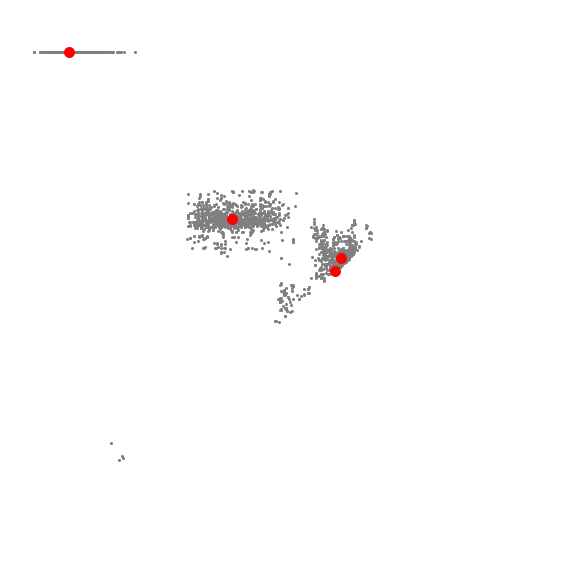

In [18]:
#all together (with Frechet means)
for k in [18]:
    for e in ["PRES16"]:
        print(e, k, "districts")
        X, Y = [], []
        PDs = storePDs[k]
        
        for PD in PDs:
            X.extend([x[0] for x in PD])
            Y.extend([x[1] for x in PD])
            
        fig = plt.figure(figsize=(8,8))
        ax = plt.gca()
        plt.axis('off')
        ax.scatter(X, Y, c="gray", s=4)
        ax.scatter([m[0] for m in meanPDs[k]], [m[1] for m in meanPDs[k]], s=100, c='red')
        plt.xlim(0,1)
        plt.ylim(0,1.1)
        plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

        plt.show()

18 PRES16 0


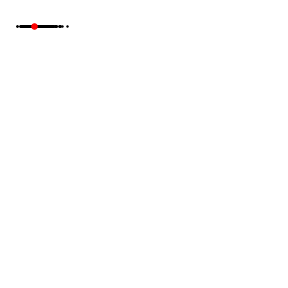

18 PRES16 1


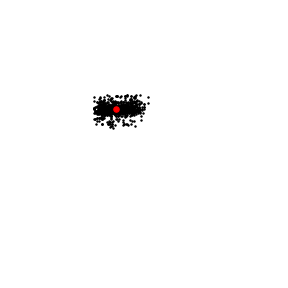

18 PRES16 2


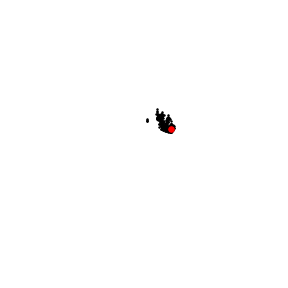

18 PRES16 3


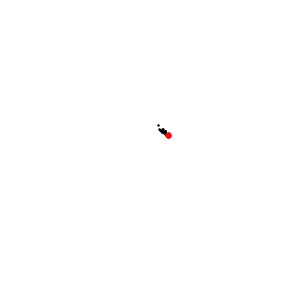

In [19]:
#by matched Frechet point
for k in [18]:
    for e in ["PRES16"]:
        PDs = []
        for PD in storePDs[k]:
            pd = match_Hungarian(PD, meanPDs[k])
            PDs.append(pd)
        for r in range(len(meanPDs[k])):
            print(k, e, r)
            nontrivialpoints = [PD[r] for PD in PDs if PD[r] not in [None, 'd']]
            X = [x[0] for x in nontrivialpoints]
            Y = [x[1] for x in nontrivialpoints]
            fig = plt.figure(figsize=(4,4))
            ax = plt.gca()
            plt.axis('off')
            ax.scatter(X, Y, c="black", s=2)
            ax.scatter([meanPDs[k][r][0]], [meanPDs[k][r][1]], s=30, c='red')
            plt.xlim(0,1)
            plt.ylim(0,1.1)
            plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
            plt.show()

## Different elections' Frechet means

18 PRES16
18 SEN16
18 ATG12
18 GOV14
18 GOV10
18 PRES12
18 SEN10
18 ATG16
18 SEN12


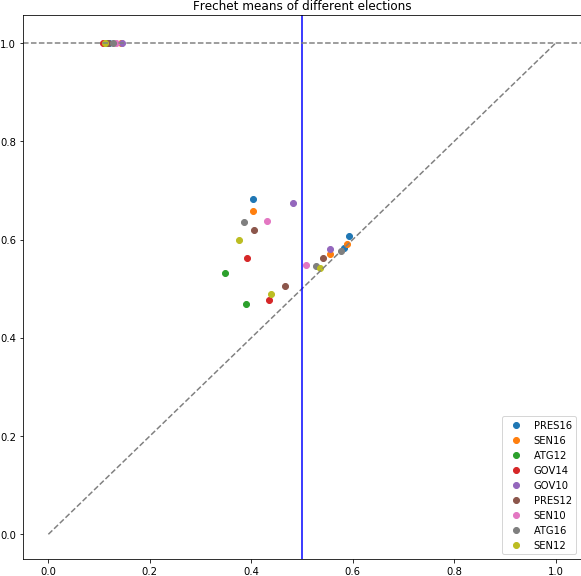

In [25]:
#plot Frechet means
for k in [18]:
    X = []
    Y = []
    labels = []
    fig, ax = plt.subplots(1, 1, figsize=(10,10))
    ax.plot([0,1], [0,1], c='gray',  linestyle='dashed')
    ax.axvline(0.5, c='blue')
    ax.axhline(1, c='gray', linestyle="dashed")
    ax.set_title("Frechet means of different elections")
    graphs = pickle.load(open(folder+"/graphs"+str(k)+".p", "rb"))
    for e in election_names:
        print(k, e)
        PDs = []
        for g in graphs[e]:
            PD = bottleneck_distance.persistence_diagram_from_graph(g[0], g[1])
            PD[-1] = (PD[-1][0], 10000)
            PDs.append(PD)
        meanPD = Frechet_mean(PDs)
        meanPD[-1] = (meanPD[-1][0], 1)
        ax.scatter(
            [m[0] for m in meanPD],
            [m[1] for m in meanPD],            
            label=e
        )
        X.extend([m[0] for m in meanPD])
        Y.extend([m[1] for m in meanPD])
        labels.extend([e for m in meanPD])
        ax.legend()
    plt.show()


## Finding geographic components (Frechet matching)

In [27]:
for k in [18]:
    allparts[k] = pickle.load(open(folder+"/parts"+str(k)+".p", "rb"))
    allgraphs[k] = pickle.load(open(folder+"/graphs" +str(k)+ ".p", "rb"))

Done creating partitions for 18 districts
PRES16
Component 0


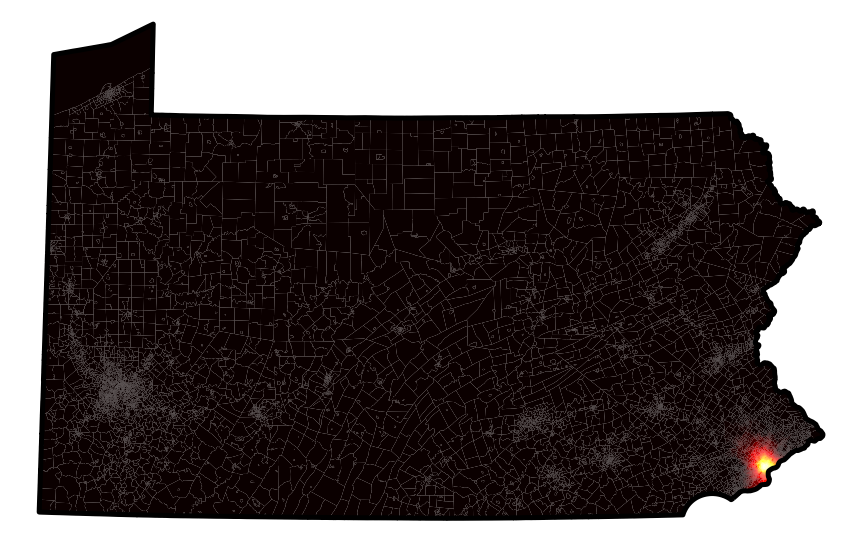

Component 1


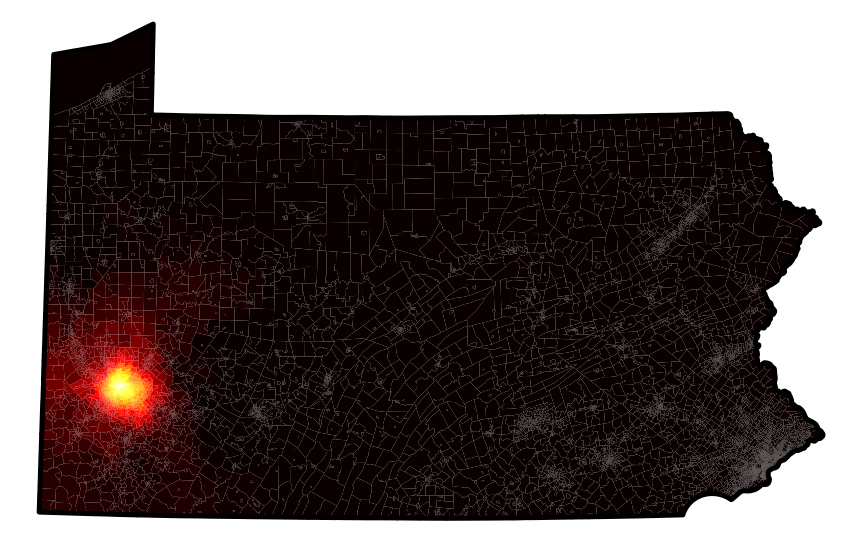

Component 2


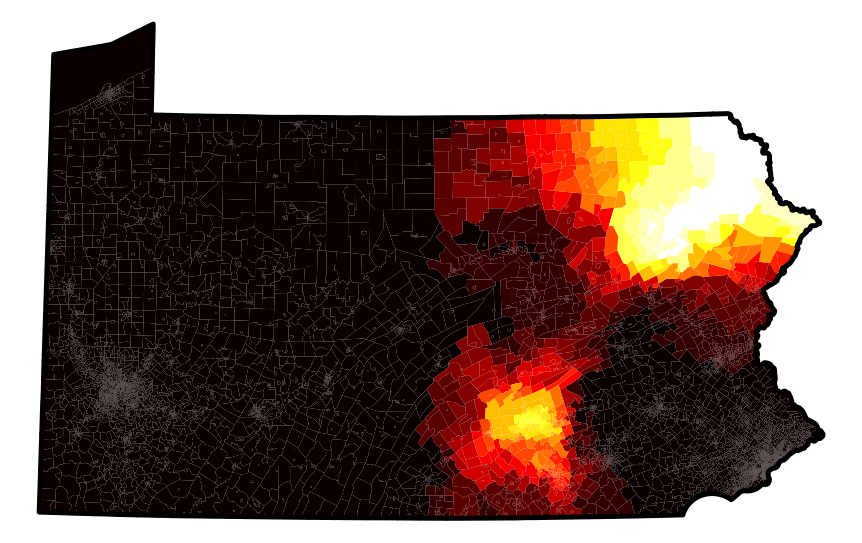

Component 3


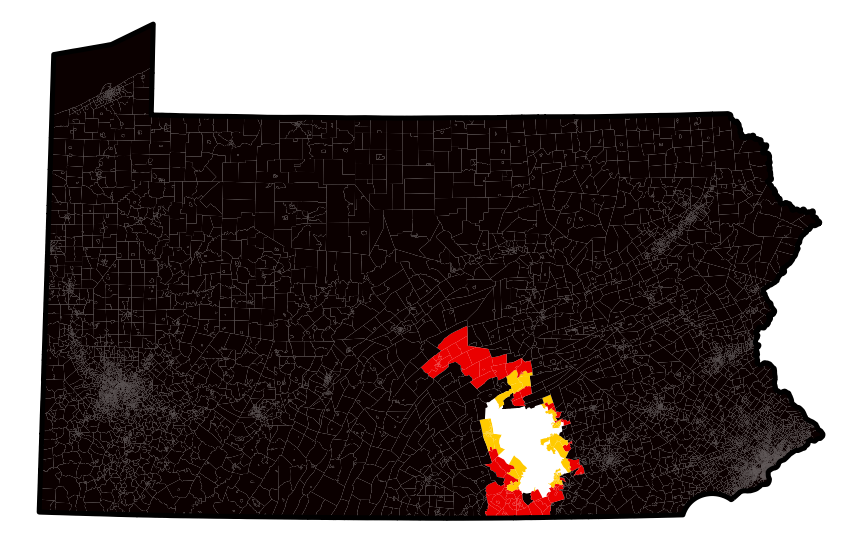

In [29]:
for k in [18]:
    asses = allparts[k]
    unrankedparts = [
        Partition(graph, x, myupdaters) for x in asses
    ]
    print("Done creating partitions for %d districts"%k)
    for e in ["PRES16"]:
        print(e)
        rankedparts = [
            bottleneck_distance.relabel_by_dem_vote_share(x, x[e]) for x in unrankedparts
        ]
        #get persistence diagrams matched to means
        PDs = []
        for PD in storePDs[k]:
            pd = match_Hungarian(PD, meanPDs[k])
            PDs.append(pd)
        #plot on map
        for r in range(len(meanPDs[k])):
            print("Component %d"%r)
            incomp = np.zeros(len(graph.nodes))
            for i, (part, PD) in enumerate(zip(rankedparts, PDs)):
                if PD[r] not in [None, 'd']:
                    birth, death = PD[r][0], PD[r][1] 
                    for n in graph.nodes:
                        #add one to node if it's in the birth district
                        dvote = sorted(part[e].percents("Democratic"))[part.assignment[n]]
                        if 1e-7 > abs(dvote - (1-birth)):
                            incomp[n] += 1
            gdf["incomp"] = incomp
            smallfig, smallax = plt.subplots(1,1,figsize=(20,10))
            gdf.plot(column="incomp", cmap="hot", ax=smallax)
            wholestate.boundary.plot(ax=smallax, linewidth=5, edgecolor="black")
            smallax.axis('off')
            plt.show()
